In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(help(mnist))

Help on Datasets in module tensorflow.contrib.learn.python.learn.datasets.base object:

class Datasets(builtins.tuple)
 |  Datasets(train, validation, test)
 |  
 |  Method resolution order:
 |      Datasets
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new OrderedDict which maps field names to their values.
 |  
 |  _replace(_self, **kwds)
 |      Return a new Datasets object replacing specified fields with new values
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  _make(iterable, new=<built-in method __new__ of type object at 0x10f0105a0>, len=<built-in function len>) from builtins.type
 |      Make a new Datasets object from a sequence or iterable
 |  
 |  -------------

In [23]:
def get_previous_features(i_layer):
    convex_dims = i_layer.get_shape().as_list()
    output_features = 1
    for dim in range(1, len(convex_dims)):
        output_features = output_features*convex_dims[dim]
    
    return output_features

def conv(input_matrix, filter_size=3, layer_depth=8,
        strides=[1,1,1,1], padding='SAME',
        is_training=True, name_scope="lx",
        stddev_n=0.05, 
        max_bool=False, max_kernel=[1,2,2,1], max_strides=[1,1,1,1],
        max_padding='SAME',
        drop_out_bool=False, drop_out_ph=None, decay=0.5):
    
    with tf.name_scope(name_scope):
        ims = input_matrix.get_shape().as_list()
        input_depth=ims[len(ims) - 1]
        W = tf.Variable(tf.truncated_normal([filter_size,filter_size,input_depth,layer_depth], stddev=stddev_n),name='W')
        b = tf.Variable(tf.constant(stddev_n, shape=[layer_depth]),name='b')
        c = tf.add(tf.nn.conv2d(input_matrix, W, strides, padding=padding), b, name='conv')
        n = tf.contrib.layers.batch_norm(c, center=True, scale=True, is_training=is_training,decay=decay)
        a = tf.nn.relu(n,name="activation")
        
        if max_bool == True:
            out = tf.nn.max_pool(a, ksize=max_kernel,strides=max_strides, padding=max_padding,name='max')
        else:
            out = a
        
        if drop_out_bool == True:
            out_  = tf.nn.dropout(out, drop_out_ph)
        else:
            out_ = out
        
        return out_


def fc(input_matrix, n=22, norm=False, prev_conv=False, stddev_n= 0.05, is_training=True,
      name_scope='FC', drop_out_bool=False, drop_out_ph=None, drop_out_v=None, decay=0.5):
    
    with tf.name_scope(name_scope):
        cvpfx = get_previous_features(input_matrix)
        if prev_conv == True:
            im = tf.reshape(input_matrix, [-1, cvpfx])
        else:
            im = input_matrix
        
        W = tf.Variable(tf.truncated_normal([cvpfx, n], stddev=stddev_n),name='W')
        b = tf.Variable(tf.constant(stddev_n, shape=[n]),name='b')
        fc = tf.add(tf.matmul(im, W),b,name="FC")
        
        if name_scope=="FCL":
            out_ = fc
        else:
            if norm==True:
                n = tf.contrib.layers.batch_norm(fc, center=True, scale=True, is_training=is_training,decay=decay)
                out = tf.nn.relu(n,name="activation")
            else:
                out = tf.nn.relu(fc,name="activation")
            if drop_out_bool==True:
                out_  = tf.nn.dropout(out, drop_out_ph)
            else:
                out_ = out
        return out_        

In [34]:
def train(ix, iy, iters=10, lr=0.001, save_model=True, save_name=None, restore_model=False,
         restore_name=None, v=False):
    
    """v: v for verbosity"""
    
    tf.reset_default_graph()
    class_output = iy.shape[1]
    d0 = ix.shape[0]
    x_shape = [None]
    
    for _ in range(1, len(ix.shape)):
        x_shape.append(ix.shape[_])
        
    print(np.array(x_shape).shape)
    
    xi = tf.placeholder(tf.float32, shape=x_shape,name='x')
    y_ = tf.placeholder(tf.float32, shape=[None,class_output],name='y')
    train_bool=tf.placeholder(bool,name='train_test')
    learning_rate = tf.placeholder(tf.float32)    

    CV1 = conv(xi,filter_size=3,layer_depth=2,name_scope="CL1",is_training=train_bool)
    CV2 = conv(CV1,filter_size=3,layer_depth=2,name_scope="CL2",is_training=train_bool)
    prediction = fc(CV2,n=class_output,name_scope="FCL",prev_conv=True)
    
    y_CNN = tf.nn.softmax(prediction,name='Softmax')
    class_pred = tf.argmax(y_CNN,1,name='ClassPred')
    loss = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_CNN), reduction_indices=[1]),name="loss")
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    print(update_ops)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    init_op = tf.global_variables_initializer()

    saver = tf.train.Saver()
    with tf.Session() as s:
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(s,restore_name)
        else:
            s.run(init_op)
            
        fd={xi:ix,y_:iy,learning_rate:lr,train_bool:True}
        for _ in range(0,iters):
            _t,l = s.run([train_step,loss],feed_dict=fd)
            if v==True:
                print("Iter:",_,"Loss:",l)
            
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(s, save_name)
                print("Model saved in file: %s" % save_name)
    

In [35]:
base_model = 'MNIST/mnist_01_.ckpt'

mtx = mnist.train.images
mtx_s = mtx.shape

x_train = np.reshape(mtx,[mtx_s[0],int(mtx_s[1]**0.5),int(mtx_s[1]**0.5),1])
print("Train shape",mtx_s)
print(x_train.shape)

limit = 16
shift = 0
y_train = mnist.train.labels

xt = x_train[shift:shift+limit,:]
yt = y_train[shift:shift+limit,:]

train(ix=xt,iy=yt,iters=10,lr=0.001,save_model=True,save_name=base_model,restore_model=False,restore_name=None)

Train shape (55000, 784)
(55000, 28, 28, 1)
(4,)
Model saved in file: MNIST/mnist_01_.ckpt


In [37]:
def restore_see_layer(ix, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {'x:0':ix, 'train_test:0':False}
                var_name=var_name+":0"
                result = s.run(var_name, feed_dict=fd)
    return result

In [56]:
base_model

'MNIST/mnist_01_.ckpt'

In [58]:
test_img = xt[0:1,:]

output_cl1 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL1/conv')
print(output_cl1.shape)

output_cl2 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL2/conv')
print(output_cl2.shape)

INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)
INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)


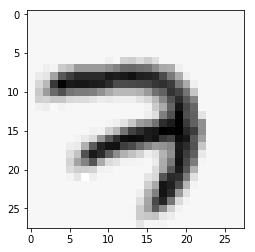

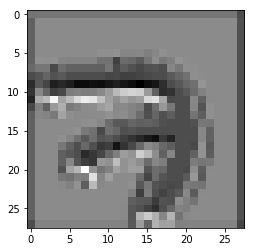

In [59]:
def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,depth_filter_to_see]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x,cmap=cmap)
    plt.show()

see_output(output_cl1,1)
see_output(output_cl2,1)

In [60]:
train(ix=xt,iy=yt,iters=1000,lr=0.001,save_model=True,save_name=base_model,restore_model=False,restore_name=None,v=True)

(4,)
Iter: 0 Loss: 2.7345378
Iter: 1 Loss: 2.2674985
Iter: 2 Loss: 1.9082654
Iter: 3 Loss: 1.6374121
Iter: 4 Loss: 1.4240829
Iter: 5 Loss: 1.2405269
Iter: 6 Loss: 1.072094
Iter: 7 Loss: 0.91249114
Iter: 8 Loss: 0.7624291
Iter: 9 Loss: 0.6266759
Iter: 10 Loss: 0.50925326
Iter: 11 Loss: 0.41158482
Iter: 12 Loss: 0.33131704
Iter: 13 Loss: 0.26676583
Iter: 14 Loss: 0.21489464
Iter: 15 Loss: 0.17297499
Iter: 16 Loss: 0.13927877
Iter: 17 Loss: 0.11251786
Iter: 18 Loss: 0.091500655
Iter: 19 Loss: 0.0750415
Iter: 20 Loss: 0.062193274
Iter: 21 Loss: 0.052024335
Iter: 22 Loss: 0.043914966
Iter: 23 Loss: 0.03743026
Iter: 24 Loss: 0.032208223
Iter: 25 Loss: 0.027964307
Iter: 26 Loss: 0.024499934
Iter: 27 Loss: 0.021649126
Iter: 28 Loss: 0.019298684
Iter: 29 Loss: 0.017332818
Iter: 30 Loss: 0.015688786
Iter: 31 Loss: 0.014303892
Iter: 32 Loss: 0.013130911
Iter: 33 Loss: 0.012134907
Iter: 34 Loss: 0.011269983
Iter: 35 Loss: 0.010531702
Iter: 36 Loss: 0.009884105
Iter: 37 Loss: 0.009308301
Iter: 38 L

Iter: 302 Loss: 0.00077116495
Iter: 303 Loss: 0.0007675148
Iter: 304 Loss: 0.00076400634
Iter: 305 Loss: 0.0007604271
Iter: 306 Loss: 0.00075691123
Iter: 307 Loss: 0.0007536303
Iter: 308 Loss: 0.00075014797
Iter: 309 Loss: 0.0007466732
Iter: 310 Loss: 0.0007431686
Iter: 311 Loss: 0.0007396863
Iter: 312 Loss: 0.0007362376
Iter: 313 Loss: 0.00073283375
Iter: 314 Loss: 0.0007294075
Iter: 315 Loss: 0.00072615646
Iter: 316 Loss: 0.00072274887
Iter: 317 Loss: 0.0007193487
Iter: 318 Loss: 0.00071636616
Iter: 319 Loss: 0.0007132158
Iter: 320 Loss: 0.0007099611
Iter: 321 Loss: 0.00070683693
Iter: 322 Loss: 0.0007035412
Iter: 323 Loss: 0.00070033874
Iter: 324 Loss: 0.0006971363
Iter: 325 Loss: 0.000694027
Iter: 326 Loss: 0.0006909141
Iter: 327 Loss: 0.000687954
Iter: 328 Loss: 0.0006848746
Iter: 329 Loss: 0.00068180636
Iter: 330 Loss: 0.0006789693
Iter: 331 Loss: 0.0006759384
Iter: 332 Loss: 0.00067292986
Iter: 333 Loss: 0.0006701152
Iter: 334 Loss: 0.00066717004
Iter: 335 Loss: 0.0006641653
Ite

Iter: 587 Loss: 0.00027663322
Iter: 588 Loss: 0.00027588793
Iter: 589 Loss: 0.00027511283
Iter: 590 Loss: 0.0002743452
Iter: 591 Loss: 0.00027359248
Iter: 592 Loss: 0.00027298133
Iter: 593 Loss: 0.00027211683
Iter: 594 Loss: 0.0002713939
Iter: 595 Loss: 0.00027061137
Iter: 596 Loss: 0.00026990334
Iter: 597 Loss: 0.00026915804
Iter: 598 Loss: 0.00026836805
Iter: 599 Loss: 0.00026771222
Iter: 600 Loss: 0.00026687753
Iter: 601 Loss: 0.00026611733
Iter: 602 Loss: 0.0002653497
Iter: 603 Loss: 0.00026463426
Iter: 604 Loss: 0.00026385172
Iter: 605 Loss: 0.0002631959
Iter: 606 Loss: 0.00026250276
Iter: 607 Loss: 0.00026179478
Iter: 608 Loss: 0.00026104203
Iter: 609 Loss: 0.00026043836
Iter: 610 Loss: 0.00025970803
Iter: 611 Loss: 0.00025899254
Iter: 612 Loss: 0.00025828456
Iter: 613 Loss: 0.00025761005
Iter: 614 Loss: 0.00025690952
Iter: 615 Loss: 0.00025619406
Iter: 616 Loss: 0.00025550096
Iter: 617 Loss: 0.00025477808
Iter: 618 Loss: 0.0002541148
Iter: 619 Loss: 0.00025343656
Iter: 620 Loss:

Iter: 869 Loss: 0.00014192585
Iter: 870 Loss: 0.0001416129
Iter: 871 Loss: 0.00014137442
Iter: 872 Loss: 0.00014109872
Iter: 873 Loss: 0.00014080809
Iter: 874 Loss: 0.00014046159
Iter: 875 Loss: 0.0001402455
Iter: 876 Loss: 0.00013996978
Iter: 877 Loss: 0.00013967918
Iter: 878 Loss: 0.0001394258
Iter: 879 Loss: 0.0001391352
Iter: 880 Loss: 0.00013886692
Iter: 881 Loss: 0.00013860612
Iter: 882 Loss: 0.00013831921
Iter: 883 Loss: 0.00013802861
Iter: 884 Loss: 0.00013780507
Iter: 885 Loss: 0.00013749953
Iter: 886 Loss: 0.00013720893
Iter: 887 Loss: 0.0001369183
Iter: 888 Loss: 0.0001366724
Iter: 889 Loss: 0.00013634453
Iter: 890 Loss: 0.00013606882
Iter: 891 Loss: 0.00013582292
Iter: 892 Loss: 0.0001355621
Iter: 893 Loss: 0.00013527522
Iter: 894 Loss: 0.00013504422
Iter: 895 Loss: 0.00013476852
Iter: 896 Loss: 0.00013444063
Iter: 897 Loss: 0.00013420962
Iter: 898 Loss: 0.00013400843
Iter: 899 Loss: 0.00013368056
Iter: 900 Loss: 0.00013341974
Iter: 901 Loss: 0.0001331664
Iter: 902 Loss: 0.

INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)
INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)


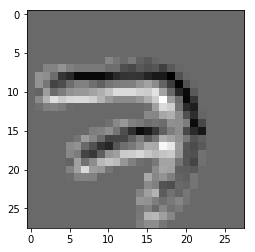

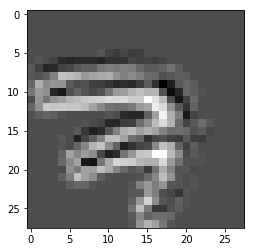

In [61]:
output_cl1 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL1/conv')
print(output_cl1.shape)

output_cl2 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL2/conv')
print(output_cl2.shape)

see_output(output_cl1,1)
see_output(output_cl2,1)

INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(3, 3, 1, 2)
INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(3, 3, 2, 2)


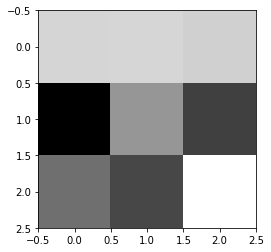

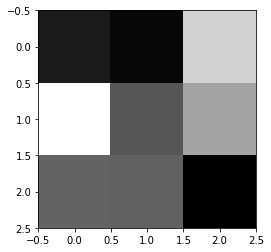

In [62]:
def see_filter(iNp,depth_filter_to_see=0,input_depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[:,:,input_depth_filter_to_see,depth_filter_to_see]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x,cmap=cmap)
    plt.show()


output_cl1_filter = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL1/W')
print(output_cl1_filter.shape)

output_cl2_filter = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL2/W')
print(output_cl2_filter.shape)

see_filter(output_cl1_filter,1)
see_filter(output_cl2_filter,1)